# <center><u> Project 3  Part 2 Core</center>
* Authored By: Eric N. Valdez
* Date: 2/11/2024

## <u>Part 2

## `Imports:`

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticks
import datetime as dt
from matplotlib import dates as mdates
import os
import glob

# Additional Imports
import itertools
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# set random seed
SEED = 321
np.random.seed(SEED)

sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)

In [2]:
# function to format y-axis units
def thousands(x, pos):
    """formats count in thousands"""
    new_x = x / 1000
    return f"{new_x:,.0f}K"

## `Custom Functions`

In [3]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [4]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [6]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

## `Load Data`

In [7]:
# loading the data
file = "Data/Chicago-Crime*.csv"
crime_data = sorted(glob.glob(file))
crime_data

['Data\\Chicago-Crime_2001.csv',
 'Data\\Chicago-Crime_2002.csv',
 'Data\\Chicago-Crime_2003.csv',
 'Data\\Chicago-Crime_2004.csv',
 'Data\\Chicago-Crime_2005.csv',
 'Data\\Chicago-Crime_2006.csv',
 'Data\\Chicago-Crime_2007.csv',
 'Data\\Chicago-Crime_2008.csv',
 'Data\\Chicago-Crime_2009.csv',
 'Data\\Chicago-Crime_2010.csv',
 'Data\\Chicago-Crime_2011.csv',
 'Data\\Chicago-Crime_2012.csv',
 'Data\\Chicago-Crime_2013.csv',
 'Data\\Chicago-Crime_2014.csv',
 'Data\\Chicago-Crime_2015.csv',
 'Data\\Chicago-Crime_2016.csv',
 'Data\\Chicago-Crime_2017.csv',
 'Data\\Chicago-Crime_2018.csv',
 'Data\\Chicago-Crime_2019.csv',
 'Data\\Chicago-Crime_2020.csv',
 'Data\\Chicago-Crime_2021.csv',
 'Data\\Chicago-Crime_2022.csv']

In [8]:
# reading the data
df = pd.concat([pd.read_csv(f, lineterminator='\n') for f in crime_data])
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
238853,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
238854,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
238855,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
238856,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [9]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
df['Date']

0        2001-01-01 01:00:00
1        2001-01-01 13:00:00
2        2001-01-01 13:00:00
3        2001-01-01 01:00:00
4        2001-01-01 01:00:00
                 ...        
238853   2022-12-31 12:50:00
238854   2022-12-31 12:50:00
238855   2022-12-31 00:52:00
238856   2022-12-31 12:52:00
238857   2022-12-31 12:59:00
Name: Date, Length: 7713109, dtype: datetime64[ns]

In [10]:
# Loading in the index
df = df.set_index('Date')
df

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
2022-12-31 12:50:00,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
2022-12-31 00:52:00,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098


In [11]:
# Creating a copy 
df_crime = df.copy()
df_crime

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
2022-12-31 12:50:00,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
2022-12-31 00:52:00,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098


In [12]:
# Resampling 
df_crime = df_crime.resample("D").sum()
df_crime

C:\Users\Valde\AppData\Local\Temp\ipykernel_23924\3794484819.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_crime = df_crime.resample("D").sum()


,ID,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,
2001-01-01,4011740634,400,378,2267987,21147.0,8194.0,72641.077994,-152199.715024
2001-01-02,1545846568,383,187,1404493,12797.0,147.0,47664.670569,-99856.853277
2001-01-03,1542074517,343,197,1462886,13359.0,132.0,48045.805839,-100651.350927
2001-01-04,1555657957,377,179,1397040,12994.0,0.0,48785.523718,-102222.916683
2001-01-05,1701884634,415,200,1530155,14044.0,156.0,52769.463977,-110554.590960
...,...,...,...,...,...,...,...,...
2022-12-27,7543189950,70,96,694723,6812.0,14192.0,21427.078656,-44887.568351
2022-12-28,7983384637,63,112,697152,6830.0,14030.0,22592.581721,-47339.899182
2022-12-29,8358666625,66,107,718511,7037.0,14292.0,23639.979313,-49528.016672


Fore this phase of the project you will be helping Chcago law enforcement allocate resources for next 6 months.

You will compare the crime count forecast for <u>`2`</u> of the options below:
* Theft
* Battery
* Narcotics
* Assault
* Total Crime `(sum of all crime types).`

**`For each of your selected crimes, perform the following steps to develop a forecast.`**
* Transform the data to obtain a time series of the crime count <u>per month using .size().</u>
* Check for and address null values
* Decompose the Time Series to detect seaonality and decide whetehr to use a seasonal model or not
* Determine if nonseasonal and / or seasonal differencing is reqired
* Use the ACF and PACF plots of stationarity data to estimate initial orders
* Split the time series into training and test data `(Remember we want to predict 6 months)`
* Fit a manual ARIMA/SARIMA model based on the orders during your exploration.
    * Make forecast with your model.
    * Plot the forecasts versus the test data
    * Obtain metrics for evaluation
* Tune with pmdarima's auto_arima
    * Fit a model n training data with the best parameters from auto_arima
    * Obtain metrics for evaluation
    * Make forecasts with the auto_arima model
    * Plot the forecasts versus the test data 
* Select the final model and justify your choice. `(Which metrics or diagnostics support yourchoice?)`
* Make true future forecasts using the entire dataset `(for dates beyond the entire ts)`

**For each of your two selected crimes, answer the following questions in a markdown cell:**
* Calculate the predicted net change in the number `(raw counts)` of this type of crime from the beginning of the forecast to the end.
* Convert the raw delta into a percent change.  

## `Theft`
## `Narcotics`
## `Total Crime`
#### might come back to process other 3 for prcatice

## `Battery`

In [13]:
battery = df[df['Primary Type']== 'BATTERY']

In [14]:
battery = battery.resample("M").size()
battery.head()

Date
2001-01-31    6527
2001-02-28    6042
2001-03-31    7662
2001-04-30    8328
2001-05-31    8887
Freq: M, dtype: int64

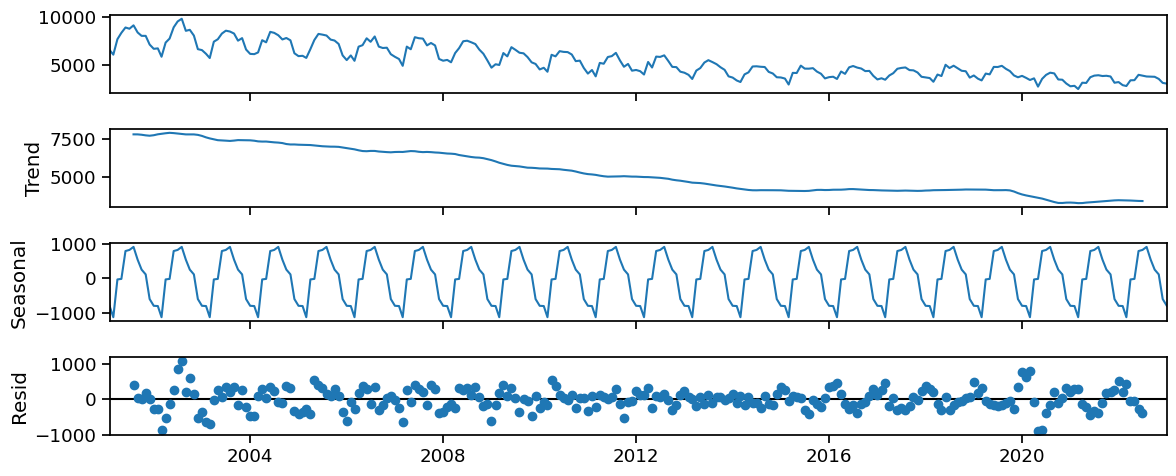

In [15]:
# Apply seasonal decomposition to check for seasonality
decomp = tsa.seasonal_decompose(battery)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [16]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/float(battery.max()-battery.min())* 100:.2f} of the variation time series.")

The seasonal component is 2040.1289682539682 which is ~27.70 of the variation time series.


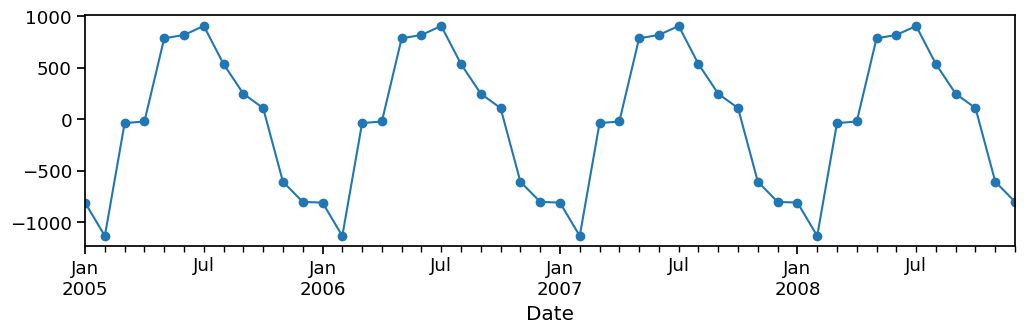

In [17]:
#plot the time series to see the seasonality
seasonal = decomp.seasonal
ax = seasonal.loc['2005': '2008'].plot(marker = 'o')

In [18]:
# Check for stationarity
get_adfuller_results(battery)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.036843,15,248,0.739591,0.05,False


In [19]:
# determine d
d = ndiffs(battery)
print (f'd = {d}')
# determine D
D = nsdiffs(battery, m = 12)
print (f'D = {D}')

d = 1
D = 0


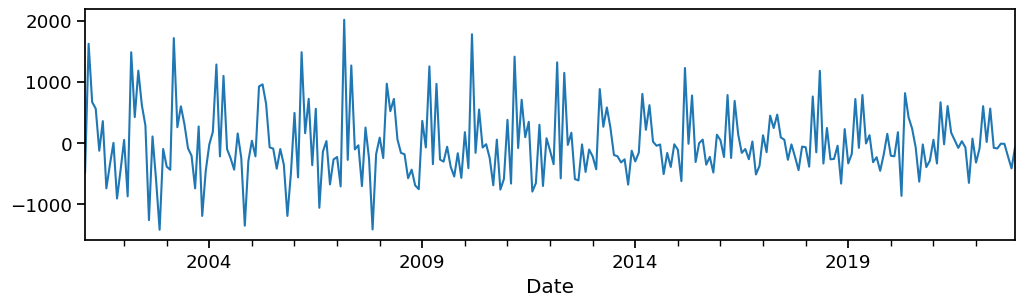

In [20]:
#apply the differencing
n_diff = battery.diff().dropna()
n_diff.plot();

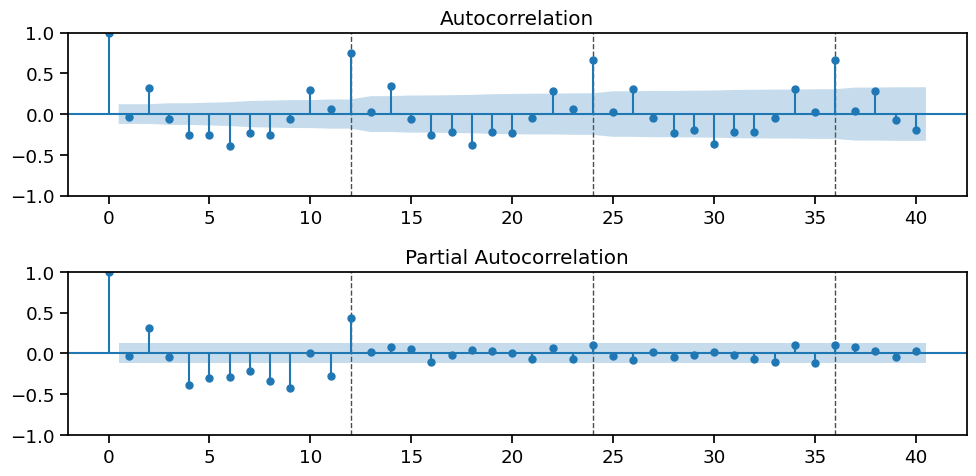

In [21]:
# now look at the acf/pacf of the stationary data
plot_acf_pacf(n_diff, annotate_seas = True, m = 12);

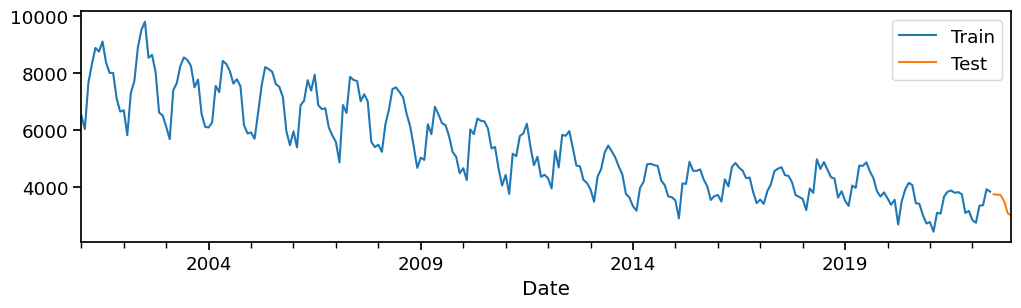

In [22]:
# tts
train, test = train_test_split(battery, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [23]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1847.393
Date:                          Fri, 23 Feb 2024   AIC                           3704.785
Time:                                  08:19:19   BIC                           3722.531
Sample:                              01-31-2001   HQIC                          3711.922
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9884      0.072     13.713      0.000       0.847       1.130
ma.L1         -0.9997      0.126     -7.959      0.000      -1.246      -0.754
ar.S.L12       0.9860      0.007    147.036      0.000       0.973       0.999
ma.S.L12      -0.7560      0.058    -13.078      0.000      -0.869      -0.643
sigma2      1.033e+05   2.22e+04      4.663      0.000    5.99e+04    1.47e+05
===================================================================================
Ljung-Box (L1) (Q):                  20.11   Jarque-Bera (JB):                 1.42
Prob(Q):                              0.00   Prob(JB):                         0.49
Heteroskedasticity (H):               0.39   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

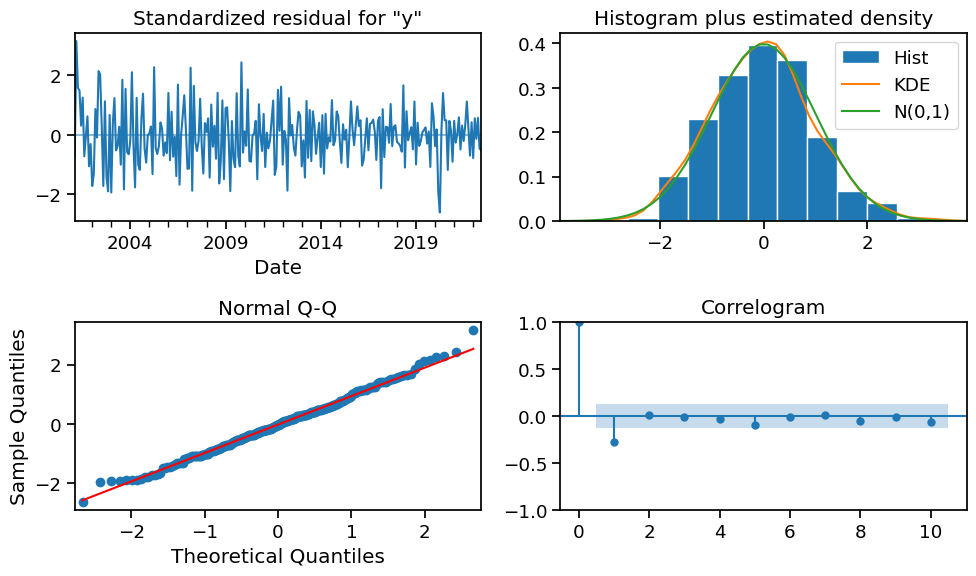

In [24]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 126.521
- MSE = 19,017.584
- RMSE = 137.904
- R^2 = 0.804
- MAPE = 3.67%


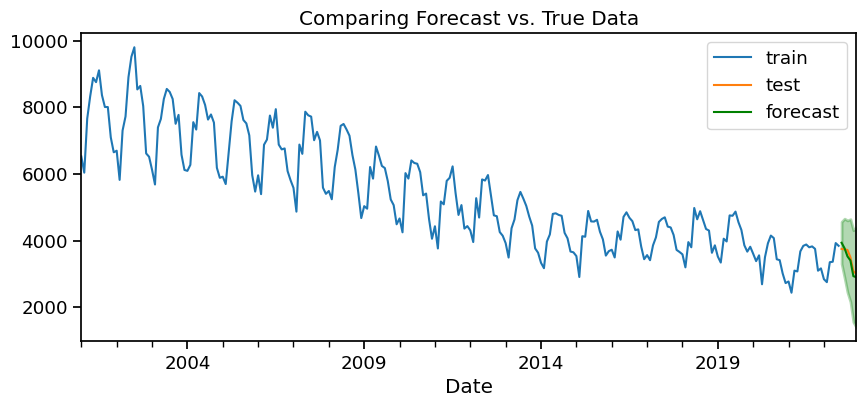

In [25]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [26]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3999.181, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3753.329, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3872.017, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3997.267, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4000.706, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3680.737, Time=0.65 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3870.170, Time=0.27 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3682.729, Time=1.56 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3682.671, Time=1.31 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3836.662, Time=0.61 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3704.855, Time=0.59 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,1)(1,0,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in 

 ARIMA(2,1,1)(1,0,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(3,1,1)(1,0,1)[12]             : AIC=inf, Time=nan sec

Best model:  ARIMA(2,1,0)(1,0,1)[12]          
Total fit time: 36.631 seconds


C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,1,1)(1,0,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in 

In [27]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  258
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1833.518
Date:                              Fri, 23 Feb 2024   AIC                           3677.037
Time:                                      08:19:57   BIC                           3694.782
Sample:                                  01-31-2001   HQIC                          3684.173
                                       - 06-30-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3590      0.056     -6.388      0.000      -0.469      -0.249
ar.L2         -0.1261      0.055     -2.290      0.022      -0.234      -0.018
ar.S.L12       0.9840      0.006    169.150      0.000       0.973       0.995
ma.S.L12      -0.6853      0.057    -12.115      0.000      -0.796      -0.574
sigma2      8.026e+04   6989.268     11.484      0.000    6.66e+04     9.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.94   Prob(JB):                         0.40
Heteroskedasticity (H):               0.42   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

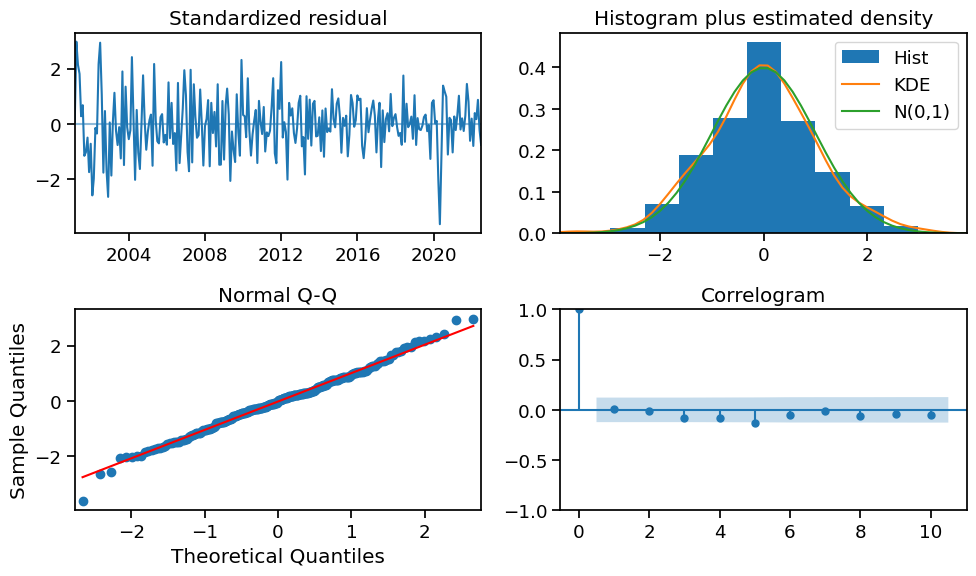

In [28]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 95.192
- MSE = 17,440.248
- RMSE = 132.062
- R^2 = 0.820
- MAPE = 2.61%


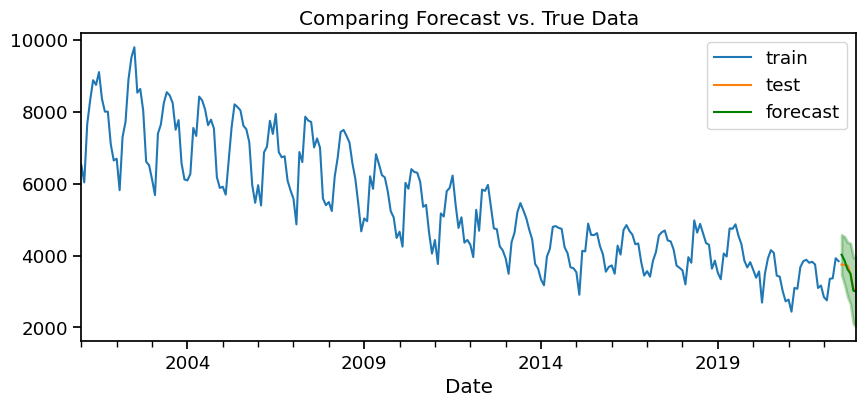

In [29]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [30]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 2  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

final_model = tsa.ARIMA(battery, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

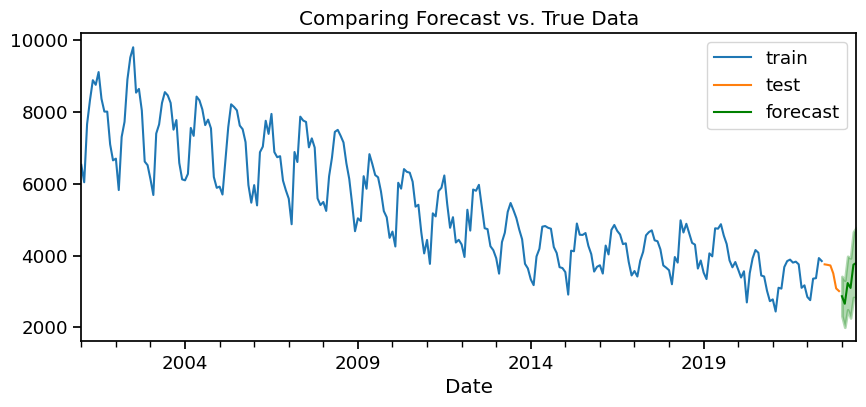

In [31]:
# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [32]:
#define the starting value of the forecast
starting_value = forecast_df['mean'].iloc[0]
starting_value

2866.591510653325

In [33]:
#define the ending value of the forecast
final_value = forecast_df['mean'].iloc[-1]
final_value

3793.4845738678378

In [34]:
#calculate the change in values
change = final_value - starting_value
change

926.893063214513

In [35]:
#calculate the change as a percentage
perc_change = (change / starting_value) * 100
perc_change

32.3343266653038

## `Assault`

In [36]:
assault = df[df['Primary Type']== 'ASSAULT']

In [37]:
assault = assault.resample("M").size()
assault.head()

Date
2001-01-31    2123
2001-02-28    2029
2001-03-31    2824
2001-04-30    2746
2001-05-31    2903
Freq: M, dtype: int64

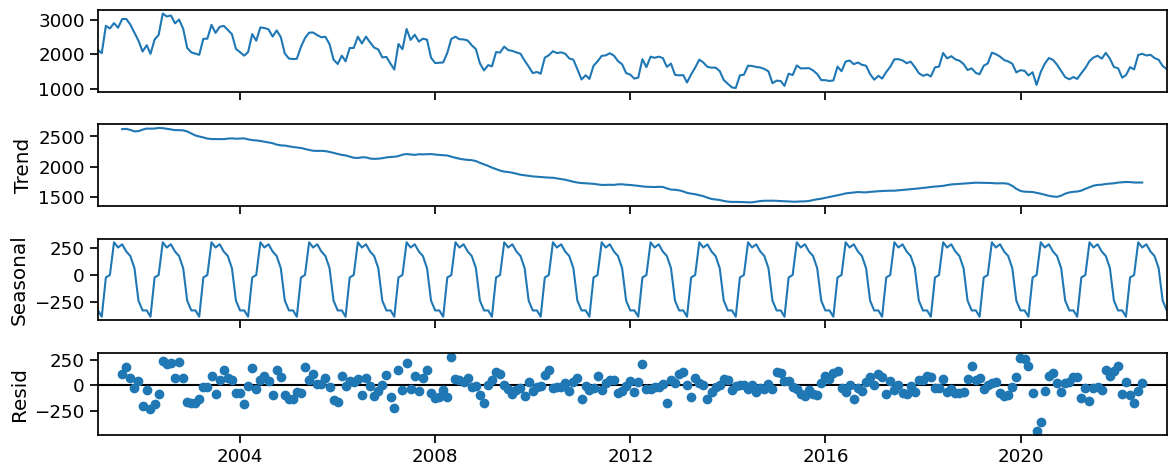

In [38]:
# Apply seasonal decomposition to check for seasonality
decomp = tsa.seasonal_decompose(assault)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [39]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

In [40]:
# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/float(assault.max()-assault.min())* 100:.2f} of the variation time series.")

The seasonal component is 684.8888888888889 which is ~31.75 of the variation time series.


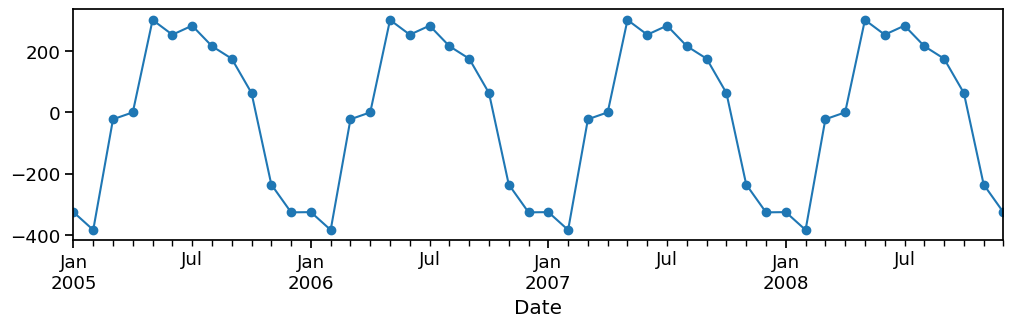

In [41]:
#plot the time series to see the seasonality
seasonal = decomp.seasonal
ax = seasonal.loc['2005': '2008'].plot(marker = 'o')

In [42]:
# Check for stationarity
get_adfuller_results(assault)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.836624,15,248,0.362437,0.05,False


In [43]:
#determine nonseasonal differencing
# determine d
d = ndiffs(assault)
print (f'd = {d}')

d = 1


In [44]:
#determine seasonal differencing
# Determine D
D = nsdiffs(assault, m =12)
print(f'D = {D}')

D = 0


In [45]:
#difference the data
assault_diff = assault.diff().dropna()

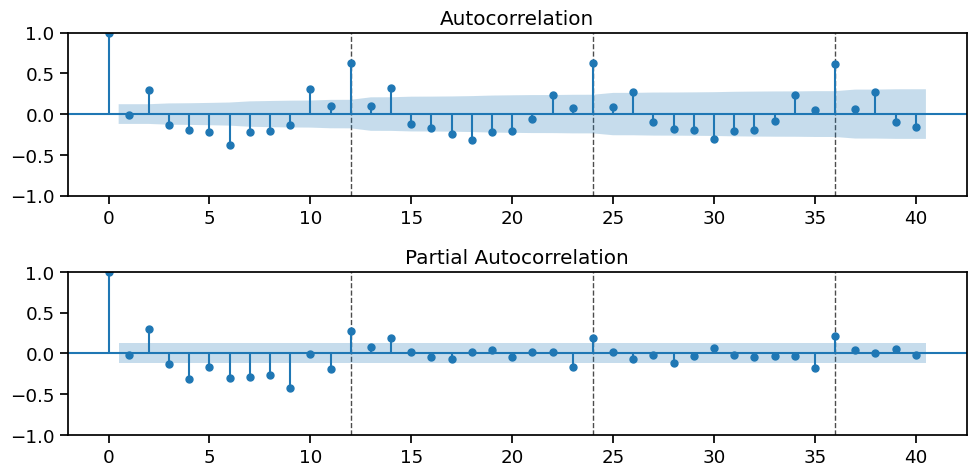

In [46]:
#find the acf and pacf
plot_acf_pacf(assault_diff, annotate_seas=True, m=12);

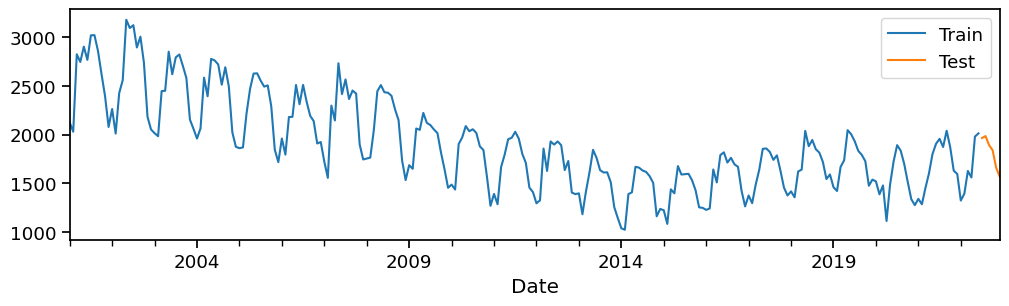

In [47]:
#test train split
atrain, atest = train_test_split(assault, test_size=6)
ax = atrain.plot(label='Train')
atest.plot(ax=ax, label='Test')
ax.legend();

In [48]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(atrain, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 72.666
- MSE = 6,561.620
- RMSE = 81.004
- R^2 = 0.723
- MAPE = 4.04%


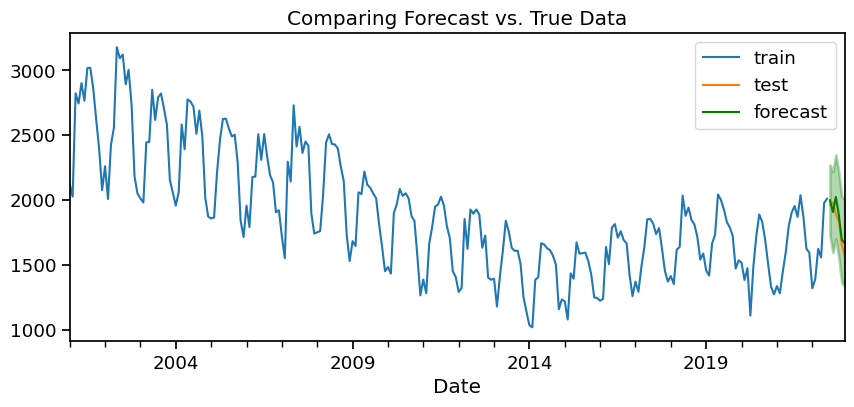

In [49]:
# Obtain summary of forecast as dataframe
aforecast_df = sarima.get_forecast(len(atest)).summary_frame()
# Plot the forecast with true values
plot_forecast(atrain, atest, aforecast_df)
# Obtain metrics
regression_metrics_ts(atest, aforecast_df["mean"])

In [50]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    atrain,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3483.860, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3318.021, Time=0.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3405.065, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3481.861, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3485.758, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3404.125, Time=0.53 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.95 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3337.645, Time=0.38 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=3313.233, Time=0.82 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3462.085, Time=0.36 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3

In [51]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  258
Model:             SARIMAX(4, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1586.058
Date:                                 Fri, 23 Feb 2024   AIC                           3192.115
Time:                                         08:21:05   BIC                           3227.606
Sample:                                     01-31-2001   HQIC                          3206.388
                                          - 06-30-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0053      0.515      0.010      0.992      -1.005       1.016
ar.L1         -0.4435      0.058     -7.583      0.000      -0.558      -0.329
ar.L2         -0.2795      0.066     -4.249      0.000      -0.408      -0.151
ar.L3         -0.2492      0.063     -3.951      0.000      -0.373      -0.126
ar.L4         -0.1597      0.063     -2.529      0.011      -0.284      -0.036
ar.S.L12       1.3958      0.211      6.603      0.000       0.981       1.810
ar.S.L24      -0.4033      0.210     -1.920      0.055      -0.815       0.008
ma.S.L12      -1.3308      0.194     -6.854      0.000      -1.711      -0.950
ma.S.L24       0.5555      0.149      3.734      0.000       0.264       0.847
sigma2      1.161e+04    947.664     12.255      0.000    9756.297    1.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                23.83
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

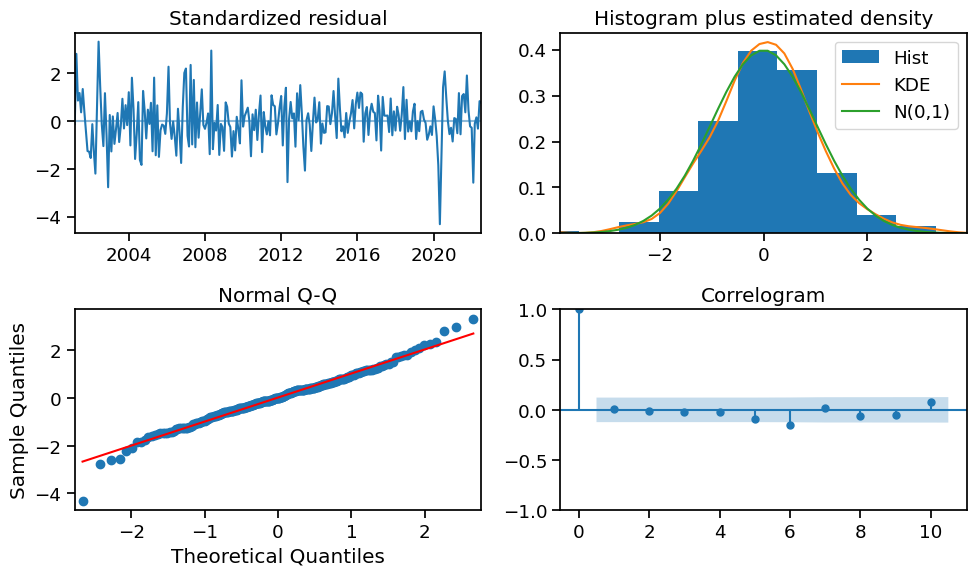

In [52]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 40.024
- MSE = 2,205.093
- RMSE = 46.958
- R^2 = 0.907
- MAPE = 2.24%


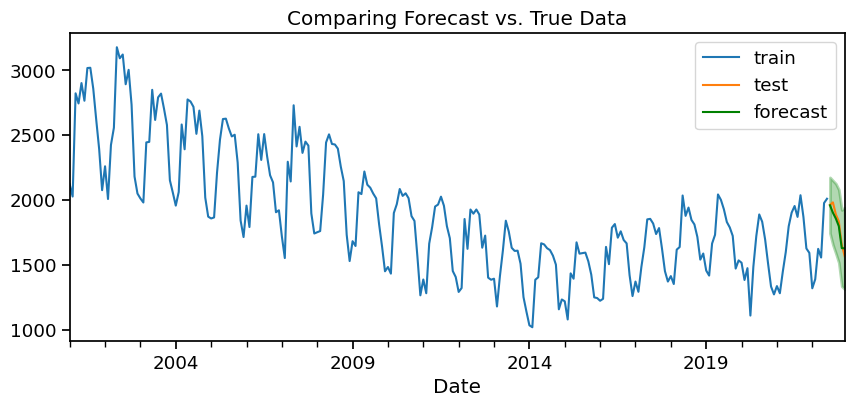

In [53]:
# Use auto_arima parameters to fit an ARIMA
auto_model = tsa.ARIMA(
    atrain, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
aforecast_df = auto_model.get_forecast(steps=len(atest)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(atrain, atest, aforecast_df);
# Obtain metrics
regression_metrics_ts(atest, aforecast_df['mean'])

In [54]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 4  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 2  # Seasonal AR
D = 0  # Seasonal differencing
Q = 2  # Seasonal MA
m = 12 # Seasonal period

final_model = tsa.ARIMA(assault, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

C:\Users\Valde\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [55]:
#find the starting and end dates of the forecast
aforecast_df.index[0],aforecast_df.index[-1]

(Timestamp('2022-07-31 00:00:00', freq='M'),
 Timestamp('2022-12-31 00:00:00', freq='M'))

In [56]:
#define the starting value of the forecast
starting_value = aforecast_df['mean'].iloc[0]
starting_value

1961.374463245738

In [57]:
#define the final value of the forecast
final_value = aforecast_df['mean'].iloc[-1]
final_value

1629.689348553915

In [58]:
#define the change in values
change = final_value - starting_value
change

-331.6851146918232

In [59]:
#calculate this change as a percentage
perc_change = (change / starting_value) * 100
perc_change

-16.910851084649142

**`Final Evaluation:`**

After completing both models and getting the forecasts for both crimes for 6 months into the future `(beyond the data),` answer the following quesitons in a <u>Markdown Cell:

### <u>Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?
* `Answer:` Battery has the highest amount fo crime.

### <u>Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?
* `Answer:` Battery highest net change

### <u> Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?
* `Answer:` Battery has the highest percentage.

## **`Final Recomendations`**

* ### What recommendation would you make to the stakeholders?
    * I would recommend that resources need to be placed towards Assault because Battery seem to be changing, however its still happening but has improved more than Assault

* ### `Include reporting_quality visual(s) to support your recommendation.`

In [ ]:
# This is Battery forecast
plot_forecast(atrain.loc['2019':],atest,aforecast_df);

In [ ]:
# This is Assault forecast
plot_forecast(train.loc['2019':],test,forecast_df);

Tableau Save

In [ ]:
## set save location 

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
print(f"[i] Saving .csv's to {OUTPUT_FOLDER}")
## loop through years
for year in year_bins:
    
    ## save temp slices of dfs to save.
    temp_df = chicago_final.loc[year]
    temp_df = temp_df.sort_index()
    temp_df = temp_df.reset_index(drop=True)
    temp_df = temp_df.drop(columns=FINAL_DROP)

    # save as csv to output folder
    fname_temp = f"{OUTPUT_FOLDER}Chicago-Crime_{year}.csv"#.gz
    temp_df.to_csv(fname_temp,index=False)

    print(f"- Succesfully saved {fname_temp}")